In [1]:
!pip install numpy==1.26.4
!pip install pandas==2.2.2
!pip install matplotlib==3.9.0
!pip install opencv-python-headless==4.10.0.82
!pip install torch==2.3.1
!pip install torchvision==0.18.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 4.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.5.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.32.4 which is incomp

In [3]:
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')


In [6]:
# Define the link to the ZIP file
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o_kRuP_Bk_Pa2xvo1ly63w/data.zip'


def normalize(image):
    """
        Normalize the image to be in range 0 to 1

        Args:
            image: The input image
        Returns:
            The normalized image
    """
    return np.array(image) / 255.0
def center_crop(img, output_size):
    """
        Crop the image from the center
        
        Args:
            img: The input image
            output_size: The size of the output image
        Returns:
            The cropped image
    """
    img = np.array(img)

    start_y = (img.shape[0] - output_size[0]) // 2
    start_x = (img.shape[1] - output_size[1]) // 2

    cropped_img = img[start_y:start_y + output_size[0], start_x:start_x + output_size[1]]
    return cropped_img

def shape_process(img, input_size):
    """
    Resize the image if its height is odd and pad it to match the input size.
    
    Args:
        img (numpy array): The input image.
        input_size (tuple): The desired size of the output image as a tuple (height, width).
        
    Returns:
        numpy array: The processed image with the specified input size.
    """
    if img.shape[0] % 2:
        img = cv.resize(img, img.shape[0] // 2, interpolation=cv.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)

    return img

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Initialize lists to hold images and labels
test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')  # Convert to grayscale
                img = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(normalize(shape_process(img, (572, 572))))
                elif '/train/labels/' in file_name:
                    cropped_img = center_crop(img, (388, 388))
                    normalized_img = normalize(cropped_img)
                    mask = (normalized_img > 0.5).astype(int)
                    train_labels.append(mask)
                elif '/test/' in file_name:
                    test_images.append(normalize(shape_process(img, (572, 572))))

    train_images = np.asarray(train_images, dtype=np.float32)
    # [N, H, W, C]
    train_images = train_images[:, :, :, np.newaxis]
    test_images = np.asarray(test_images, dtype=np.float32)
    test_images = test_images[:, :, :, np.newaxis]

    train_labels = np.asarray(train_labels, dtype=np.float32)
    train_labels = train_labels[:, :, :, np.newaxis]


In [7]:
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')

train_images.shape: (30, 572, 572, 1)
train_labels.shape: (30, 388, 388, 1)
test_images.shape: (30, 572, 572, 1)


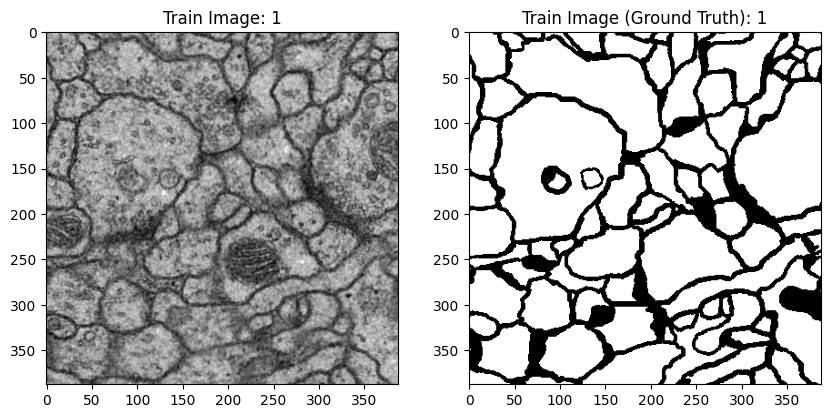

In [8]:
sample_image_index = 1

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

In [9]:
from torch import nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.conv1 = self.double_conv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = self.double_conv(512, 1024)

        # Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1 
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1 
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # concat conv3 + up_conv2
        self.conv7 = self.double_conv(256 + 256, 256)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # concat conv2 + up_conv3
        self.conv8 = self.double_conv(128 + 128, 128)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # concat conv1 + up_conv4
        self.conv9 = self.double_conv(64 + 64, 64)

        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, source_tensor, target_shape):
        start_y = (source_tensor.shape[2] - target_shape[2]) // 2
        start_x = (source_tensor.shape[3] - target_shape[3]) // 2

        return source_tensor[:, :, start_y:start_y + target_shape[2], start_x:start_x + target_shape[3]]

    def forward(self, x):
        # Downsampling path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        x = self.conv5(p4)

        x = self.up_conv1(x)
        x = torch.cat((self.center_crop(c4, x.shape), x), dim=1)
        x = self.conv6(x)

        x = self.up_conv2(x)
        x = torch.cat((self.center_crop(c3, x.shape), x), dim=1)
        x = self.conv7(x)

        x = self.up_conv3(x)
        x = torch.cat((self.center_crop(c2, x.shape), x), dim=1)
        x = self.conv8(x)

        x = self.up_conv4(x)
        x = torch.cat((self.center_crop(c1, x.shape), x), dim=1)
        x = self.conv9(x)

        output = torch.sigmoid(self.conv10(x))

        return output

In [10]:
model = UNet()
print(model)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [13]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create data loaders
batch_size = 1

# Create tensors for the first 6 images (3 for training, 3 for validation)
train_tensor = torch.from_numpy(train_images[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

# Set seed for reproducibility
torch.manual_seed(42)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

In [14]:
input_tensor = torch.randn(1, 1, 572, 572)


def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")


for layer in model.children():
    layer.register_forward_hook(print_size)


with torch.no_grad():
    output = model(input_tensor)

print("Final output size:", output.size())

Sequential output size: torch.Size([1, 64, 568, 568])
MaxPool2d output size: torch.Size([1, 64, 284, 284])
Sequential output size: torch.Size([1, 128, 280, 280])
MaxPool2d output size: torch.Size([1, 128, 140, 140])
Sequential output size: torch.Size([1, 256, 136, 136])
MaxPool2d output size: torch.Size([1, 256, 68, 68])
Sequential output size: torch.Size([1, 512, 64, 64])
MaxPool2d output size: torch.Size([1, 512, 32, 32])
Sequential output size: torch.Size([1, 1024, 28, 28])
ConvTranspose2d output size: torch.Size([1, 512, 56, 56])
Sequential output size: torch.Size([1, 512, 52, 52])
ConvTranspose2d output size: torch.Size([1, 256, 104, 104])
Sequential output size: torch.Size([1, 256, 100, 100])
ConvTranspose2d output size: torch.Size([1, 128, 200, 200])
Sequential output size: torch.Size([1, 128, 196, 196])
ConvTranspose2d output size: torch.Size([1, 64, 392, 392])
Sequential output size: torch.Size([1, 64, 388, 388])
Conv2d output size: torch.Size([1, 1, 388, 388])
Final output si

# Creating data loaders for training

In [15]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create data loaders
batch_size = 1

# Create tensors for the first 6 images (3 for training, 3 for validation)
train_tensor = torch.from_numpy(train_images[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

# Set seed for reproducibility
torch.manual_seed(42)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Training the U-Net model

In [16]:
from tqdm.notebook import tqdm

model = UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 20

train_losses = []
val_losses = []

# Training and validation loop
for e in tqdm(range(epochs), leave=False, desc="Epoch"):
    model.train()
    epoch_train_loss = 0  # To accumulate loss for each epoch

    for data, labels in tqdm(train_dl, leave=False, desc="   Training Dataset"):
        optim.zero_grad()
        prediction = model(data)
        loss = F.mse_loss(prediction, labels)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()  # Summing up the loss for the epoch

    average_train_loss = epoch_train_loss / len(train_dl)
    train_losses.append(average_train_loss)

    # Validation step
    model.eval()
    epoch_val_loss = 0  # To accumulate loss for validation
    with torch.no_grad():
        for data, labels in tqdm(val_dl, leave=False, desc="   Validation Dataset"):
            prediction = model(data)
            loss = F.mse_loss(prediction, labels)
            epoch_val_loss += loss.item()  # Summing up the loss for the epoch

    average_val_loss = epoch_val_loss / len(val_dl)
    val_losses.append(average_val_loss)

    print(f"Epoch {e+1}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.2435, Val Loss: 0.2398


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.2390, Val Loss: 0.2351


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.2344, Val Loss: 0.2294


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.2281, Val Loss: 0.2210


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.2187, Val Loss: 0.2065


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.2009, Val Loss: 0.1736


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1893, Val Loss: 0.1709


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1803, Val Loss: 0.1715


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.1789, Val Loss: 0.1679


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1765, Val Loss: 0.1647


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.1747, Val Loss: 0.1628


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.1726, Val Loss: 0.1610


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.1702, Val Loss: 0.1590


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.1678, Val Loss: 0.1565


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.1649, Val Loss: 0.1526


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.1615, Val Loss: 0.1489


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.1579, Val Loss: 0.1459


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.1532, Val Loss: 0.1399


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.1476, Val Loss: 0.1336


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.1429, Val Loss: 0.1258


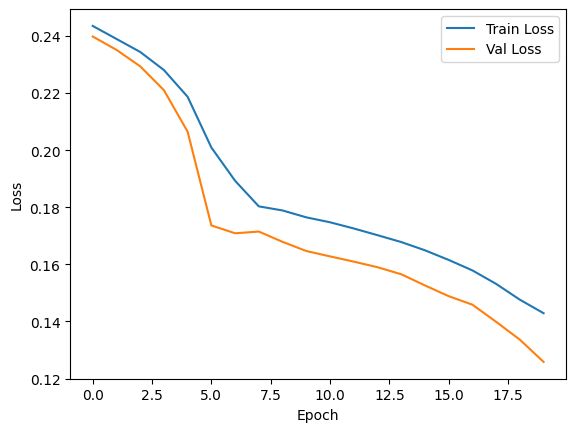

In [17]:
# Plot the loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
def download_pt_file(url):
    response = requests.get(url)
    return io.BytesIO(response.content)


pt_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Iu482aowoEaP9MgNqhyJ_w/model-epo300.pt'
state_dict = torch.load(download_pt_file(pt_file_url), map_location=torch.device(device))

model = UNet().to(device)
model.load_state_dict(state_dict)
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

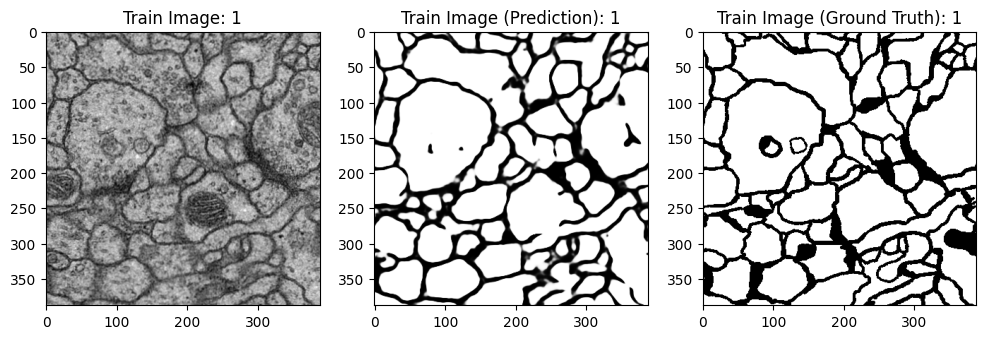

In [19]:
# Try different sample_image_index here.
sample_image_index = 1

predictions = []
test_tensor = torch.from_numpy(train_images[sample_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 3, 2)
plt.imshow(make_grid(prediction)[0].numpy(), cmap='gray')
plt.title(f'Train Image (Prediction): {sample_image_index}')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

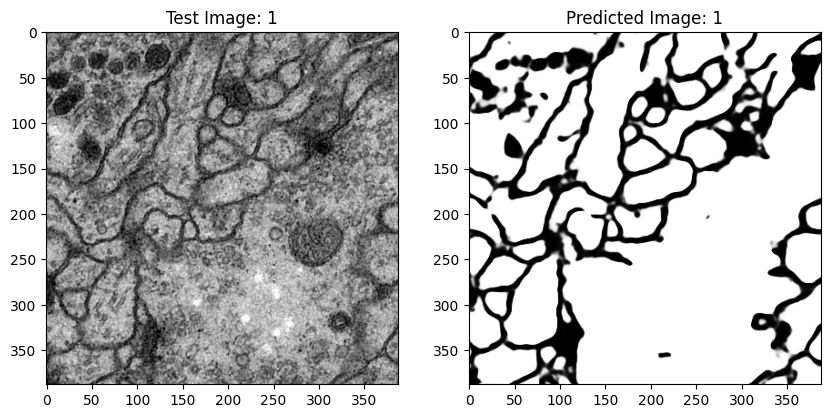

In [20]:
test_image_index = 1

predictions = []
test_tensor = torch.from_numpy(test_images[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction)[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()

In [24]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import torch

@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    all_true = []
    all_pred = []

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        logits = model(images)

        # For binary segmentation (1 channel output)
        if logits.shape[1] == 1:
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(1)
        else:
            preds = torch.argmax(logits, dim=1)

        if masks.ndim == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)

        all_true.append(masks.view(-1).cpu().numpy())
        all_pred.append(preds.view(-1).cpu().numpy())

    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)

    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, zero_division=0)

    print("=== Model Accuracy (Validation Set) ===")
    print(f"{acc:.4f}\n")
    print("=== Classification Report ===")
    print(report)

    return acc, report


acc, report = evaluate_model(model, val_dl, device)


=== Model Accuracy (Validation Set) ===
0.7671

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       1.00      0.01      0.01     70525
         1.0       0.77      1.00      0.87    230563

    accuracy                           0.77    301088
   macro avg       0.88      0.50      0.44    301088
weighted avg       0.82      0.77      0.67    301088

